# SMARCC2


[Coffin-Siris syndrome-8 (CSS8)](https://www.omim.org/entry/618362) is inherited autosomal dominant characterized by variable degrees of impaired intellectual development including speech impairment, hypotonia, feeding difficulties, and behavioral abnormalities. Dysmorphic features may or may not be present and include hypertrichosis or thin scalp hair, thick eyebrows, thin upper vermilion, and upturned nose [Machol et al., 2019](https://pubmed.ncbi.nlm.nih.gov/30580808/). 

We performed the following PubMed query on 2024-09-26 

> ("Coffin-Siris syndrome type 8" OR CSS8 OR "Coffin-Siris syndrome 8") AND (SMARCC2 OR "SMARCC2 variants" OR "SMARCC2 mutations") AND ("genotype phenotype correlation" OR " phenotype genotype correlation")


This query returned on article [PMID:34881817](https://pubmed.ncbi.nlm.nih.gov/34881817/), which reported on two individuals affected by CSS8 showing a similar clinical manifestations with two severe variants c.1824_1826del, p.(Leu609del) and  c.1094_1097delAGAA, p.(Lys365Thrfs*12)

Further we found the article: Elucidating the clinical and molecular spectrum of SMARCC2-associated NDD in a cohort of 65 affected individuals - Bosch E, et al (2023), [https://doi.org/10.1016/j.gim.2023.100950)], which reported on the following significant correlations between missense and truncating variants: 

**"_p values missense versus truncating variant cohorts_"** for 
 - Global developmental delay; Intellectual disability (HP:0001263;HP:0001249):          p = 0.005 (FDR-corr: 0.033)
 - Muscular hypotonia (HP:0001252):                                                      p = 0.004 (FDR-corr: 0.033)
 - mild GDD/ID (HP:0011342;HP:0001256):                                                  p = 0.012 (FDR-corr: 0.051)
 - Abnormality of the outer ear (HP:0000356):                                            p = 0.013 (FDR-corr: 0.051)
 - Decreased body weight (HP:0004325):                                                   p = 0.002 (FDR-corr: 0.024)
 - Abnormality of the eye (HP:0000478):                                                  p = 0.000 (FDR-corr: 0.008)
 - Short stature (HP:0004322):                                                           p = 0.006 (FDR-corr: 0.035)
 - Feeding difficulties/failure to thrive (HP:0011968;HP:0001508)                        p = 0.013 (FDR-corr: 0.051)

In [1]:
import gpsea
import hpotk

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo()
print(f'Loaded HPO v{hpo.version}')
print(f"Using genophenocorr version {gpsea.__version__}")

Loaded HPO v2025-01-16
Using genophenocorr version 0.9.4


### SMARCC2

We use the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for SMARCC2.

In [2]:
from gpsea.preprocessing import configure_default_protein_metadata_service
gene_symbol = 'SMARCC2'
mane_tx_id = 'NM_001330288.2'
mane_protein_id = 'NP_001317217.1'
pms = configure_default_protein_metadata_service()
protein_meta = pms.annotate(mane_protein_id)

In [3]:
from ppktstore.registry import configure_phenopacket_registry
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets

phenopacket_registry = configure_phenopacket_registry()
with phenopacket_registry.open_phenopacket_store('0.1.24') as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))

cohort_creator = configure_caching_cohort_creator(hpo)
cohort, validation = load_phenopackets(  
    phenopackets=phenopackets,
    cohort_creator=cohort_creator,
)
validation.summarize()

Individuals Processed: 100%|██████████| 65/65 [00:01<00:00, 45.12 individuals/s]
Validated under permissive policy
Showing errors and warnings
Phenopackets
  patient #5
    individual
     warnings:
     ·ontology_class of the time_at_last_encounter field cannot be parsed into age. Consider formatting the age as ISO8601 duration (e.g., "P31Y2M" for 31 years and 2 months)
  patient #20
    individual
     warnings:
     ·ontology_class of the time_at_last_encounter field cannot be parsed into age. Consider formatting the age as ISO8601 duration (e.g., "P31Y2M" for 31 years and 2 months)


In [4]:
from gpsea.view import CohortViewer

viewer = CohortViewer(hpo)
viewer.process(cohort=cohort, transcript_id=mane_tx_id)

n,HPO Term
50,Intellectual disability
40,Hypotonia
28,Feeding difficulties
28,Failure to thrive
24,Thin upper lip vermilion
21,Thick eyebrow
21,Mild global developmental delay
20,Autistic behavior
17,Thick lower lip vermilion
17,Everted lower lip vermilion


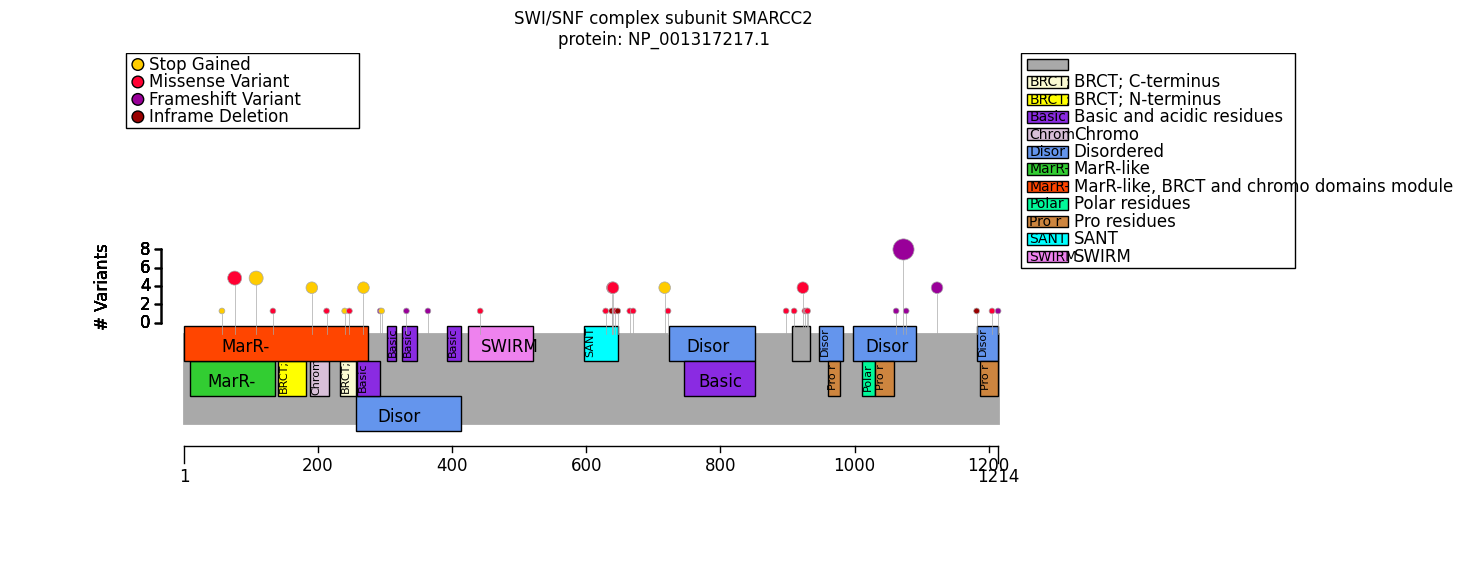

In [5]:
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt

smarcc2_fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein(
    protein_metadata=protein_meta,
    cohort=cohort,
    ax=ax,
)
smarcc2_fig.tight_layout()

In [6]:
from gpsea.view import ProteinVariantViewer
pvv = ProteinVariantViewer(protein_metadata=protein_meta, tx_id=mane_tx_id)
pvv.process(cohort)

Count,Name,Type,Coordinates,Variants
15,"MarR-like, BRCT and chromo domains module",Region,2 - 274,p.Trp241Ter; p.Tyr109Ter; p.Asn134Asp; p.Phe248Ser; p.Thr214Ala; p.Arg192Ter; p.Arg269Ter; p.Gln58Ter; p.Pro77Leu
8,MarR-like,Domain,11 - 136,p.Gln58Ter; p.Pro77Leu; p.Tyr109Ter; p.Asn134Asp
0,BRCT; N-terminus,Domain,141 - 183,
3,Chromo,Domain,190 - 217,p.Thr214Ala; p.Arg192Ter
2,BRCT; C-terminus,Domain,234 - 257,p.Trp241Ter; p.Phe248Ser
6,Disordered,Region,258 - 413,p.Gly294LysfsTer3; p.Glu334ArgfsTer49; p.Arg269Ter; p.Lys365ThrfsTer12; p.Tyr296Ter
2,Basic and acidic residues,Compositional bias,259 - 292,p.Arg269Ter
0,Basic and acidic residues,Compositional bias,304 - 317,
1,Basic and acidic residues,Compositional bias,327 - 348,p.Glu334ArgfsTer49
0,Basic and acidic residues,Compositional bias,394 - 413,


## Genotype-Phenotype Correlation (GPC) Analysis

In [7]:
from gpsea.analysis.clf import prepare_classifiers_for_terms_of_interest
from gpsea.analysis.pcats import configure_hpo_term_analysis

analysis = configure_hpo_term_analysis(hpo)
pheno_clfs = prepare_classifiers_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

In [8]:
from gpsea.model import VariantEffect
from gpsea.view import MtcStatsViewer
from gpsea.analysis.predicate import variant_effect, anyof
from gpsea.analysis.clf import monoallelic_classifier

missense = variant_effect(VariantEffect.MISSENSE_VARIANT, mane_tx_id)
nonsense = variant_effect(VariantEffect.STOP_GAINED, tx_id=mane_tx_id)
frameshift = variant_effect(VariantEffect.FRAMESHIFT_VARIANT, tx_id=mane_tx_id)
truncating = anyof((nonsense, frameshift))

missense_clf = monoallelic_classifier(
    a_predicate=missense,
    b_predicate=truncating,
    a_label="Missense",
    b_label="Truncating"
)

missense_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=missense_clf,
    pheno_clfs=pheno_clfs,
)

viewer = MtcStatsViewer()
viewer.process(missense_result)

Code,Reason,Count
HMF01,Skipping term with maximum frequency that was less than threshold 0.4,73
HMF03,Skipping term because of a child term with the same individual counts,6
HMF08,Skipping general term,56
HMF09,Skipping term with maximum annotation frequency that was less than threshold 0.4,150


In [9]:
from gpsea.view import summarize_hpo_analysis
summarize_hpo_analysis(hpo=hpo, result=missense_result)

Allele group,Missense,Truncating,Corrected p values,p values
Moderate global developmental delay [HP:0011343],10/23 (43%),1/23 (4%),0.070508,0.004148
Mild global developmental delay [HP:0011342],6/23 (26%),14/23 (61%),0.307217,0.036143
Intellectual disability [HP:0001249],22/23 (96%),17/23 (74%),0.543524,0.095916
Hypotonia [HP:0001252],18/23 (78%),13/23 (57%),0.596789,0.207811
Failure to thrive [HP:0001508],13/23 (57%),8/23 (35%),0.596789,0.236189
Thin upper lip vermilion [HP:0000219],8/23 (35%),13/23 (57%),0.596789,0.236189
Feeding difficulties [HP:0011968],13/23 (57%),8/21 (38%),0.596789,0.245737
Autistic behavior [HP:0000729],7/23 (30%),11/25 (44%),0.814037,0.383076
Abnormal nasal morphology [HP:0005105],11/11 (100%),17/17 (100%),1.000000,1.000000
Abnormality of the philtrum [HP:0000288],12/12 (100%),14/14 (100%),1.000000,1.000000


In [10]:
from gpsea.analysis.predicate import variant_key

c3222del = variant_key("12_56165327_56165328_CA_C") # c.3222del; p.Gly1075AspfsTer17

c3222del_clf = monoallelic_classifier(
    a_predicate=c3222del,
    b_predicate=~c3222del,
    a_label = "c.3222del",
    b_label="other"
)
c3222del_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=c3222del_clf,
    pheno_clfs=pheno_clfs,
)
summarize_hpo_analysis(hpo=hpo, result=c3222del_result)

Allele group,c.3222del,other,Corrected p values,p values
Intellectual disability [HP:0001249],1/6 (17%),49/52 (94%),0.001677,0.000070
Autistic behavior [HP:0000729],7/8 (88%),13/51 (25%),0.017042,0.001420
Wide nose [HP:0000445],3/6 (50%),11/48 (23%),1.000000,0.172693
Prominent forehead [HP:0011220],3/6 (50%),11/41 (27%),1.000000,0.343760
Feeding difficulties [HP:0011968],2/6 (33%),26/50 (52%),1.000000,0.669458
Failure to thrive [HP:0001508],2/6 (33%),26/52 (50%),1.000000,0.671391
Abnormal eyelid morphology [HP:0000492],1/1 (100%),29/29 (100%),1.000000,1.000000
Global developmental delay [HP:0001263],1/1 (100%),49/49 (100%),1.000000,1.000000
Neurodevelopmental abnormality [HP:0012759],1/1 (100%),49/49 (100%),1.000000,1.000000
Abnormal eyebrow morphology [HP:0000534],2/2 (100%),24/24 (100%),1.000000,1.000000


## Correlation of **Region 1 - 274: MarR-like, BRCT and chromo domains module vs Other Regions**

In [11]:
from gpsea.model.genome import Region
from gpsea.analysis.predicate import protein_region

nterm_region = Region(start=1, end=274)
is_n_term = protein_region(region=nterm_region, tx_id=mane_tx_id)

nterm_clf = monoallelic_classifier(
    a_predicate=is_n_term,
    b_predicate=~ is_n_term,
    a_label ="N term",
    b_label = "Other"
)
nterm_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=nterm_clf,
    pheno_clfs=pheno_clfs,
)
summarize_hpo_analysis(hpo=hpo, result=nterm_result)

Allele group,N term,Other,Corrected p values,p values
Mild global developmental delay [HP:0011342],11/15 (73%),10/43 (23%),0.027121,0.001179
Hypotonia [HP:0001252],7/15 (47%),33/43 (77%),0.576792,0.050156
Thin upper lip vermilion [HP:0000219],9/15 (60%),15/41 (37%),1.000000,0.138375
Failure to thrive [HP:0001508],5/15 (33%),23/43 (53%),1.000000,0.235402
Feeding difficulties [HP:0011968],5/14 (36%),23/42 (55%),1.000000,0.355036
Thick eyebrow [HP:0000574],4/15 (27%),17/41 (41%),1.000000,0.366044
Decreased body weight [HP:0004325],6/7 (86%),25/26 (96%),1.000000,0.384470
Intellectual disability [HP:0001249],14/15 (93%),36/43 (84%),1.000000,0.666043
Abnormal upper lip morphology [HP:0000177],11/11 (100%),30/30 (100%),1.000000,1.000000
Abnormal lip morphology [HP:0000159],12/12 (100%),32/32 (100%),1.000000,1.000000


In [12]:
from gpsea.analysis.clf import sex_classifier

mf_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=sex_classifier(),
    pheno_clfs=pheno_clfs,
)
summarize_hpo_analysis(hpo=hpo, result=mf_result)

Sex,FEMALE,MALE,Corrected p values,p values
Wide nose [HP:0000445],9/21 (43%),5/33 (15%),0.562497,0.030547
Mild global developmental delay [HP:0011342],12/23 (52%),9/35 (26%),0.562497,0.053278
Thick nasal alae [HP:0009928],9/21 (43%),6/33 (18%),0.562497,0.065170
Autistic behavior [HP:0000729],4/22 (18%),16/37 (43%),0.562497,0.086538
Thick eyebrow [HP:0000574],11/22 (50%),10/34 (29%),0.746843,0.160671
Decreased body weight [HP:0004325],12/14 (86%),19/19 (100%),0.746843,0.172348
Intellectual disability [HP:0001249],21/23 (91%),29/35 (83%),1.000000,0.458174
Failure to thrive [HP:0001508],10/23 (43%),18/35 (51%),1.000000,0.600052
Hypotonia [HP:0001252],15/23 (65%),25/35 (71%),1.000000,0.772684
Thin upper lip vermilion [HP:0000219],10/22 (45%),14/34 (41%),1.000000,0.788016


## Summary

In [13]:
from gpseacs.report import GpseaAnalysisReport, GPAnalysisResultSummary

fet_results = (
    GPAnalysisResultSummary.from_multi(
        result=missense_result,
    ),
    GPAnalysisResultSummary.from_multi(
        result=c3222del_result,
    ),
    GPAnalysisResultSummary.from_multi(
        result=nterm_result,
    ),
    GPAnalysisResultSummary.from_multi(
        result=mf_result,
    ),
)

report = GpseaAnalysisReport(
    name=gene_symbol, 
    cohort=cohort, 
    fet_results=fet_results,
    gene_symbol=gene_symbol,
    mane_tx_id=mane_tx_id,
    mane_protein_id=mane_protein_id,
)

In [14]:
from gpseacs.report import GpseaNotebookSummarizer

summarizer = GpseaNotebookSummarizer(hpo=hpo, gpsea_version=gpsea.__version__)
summarizer.summarize_report(report=report)

In [15]:
summarizer.process_latex(report=report, protein_fig=smarcc2_fig)

Figure saved to ../../supplement/img/SMARCC2_protein_diagram-draft.pdf
Output to ../../supplement/tex/SMARCC2_summary_draft.tex


*-* EOF *-*